C:\Users\swl00\AppData\Local\Temp\ipykernel_33812\2491716779.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)


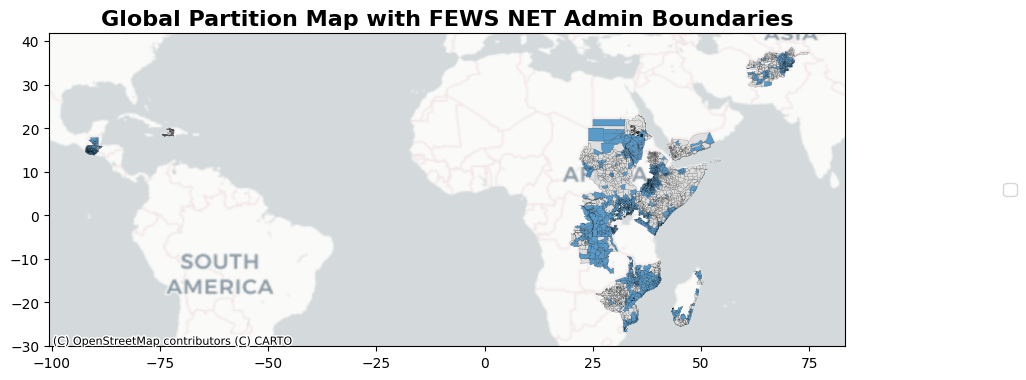

In [6]:
# rename fews_ipc_crisis_pred as alert_status, fews_ipc_crisis_true as actual_alert_status
df_joined.rename(columns={
    'fews_ipc_crisis_pred': 'alert_status',
    'fews_ipc_crisis_true': 'actual_alert_status'
}, inplace=True)

In [ ]:

# --- Configuration for the plot grid ---
years_to_plot = [2021, 2022, 2023, 2024] # years to plot
status_columns_info = {
    'actual_alert_status': 'Actual Alert Status',
    'alert_status': 'Predicted Alert Status'
}
plot_columns_keys = list(status_columns_info.keys())

# --- Nature-like Style Adjustments ---
plt.rcParams.update({
    'font.family': 'sans-serif', # Use a sans-serif font
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans', 'Bitstream Vera Sans'], # Preferred sans-serif fonts
    'axes.titlesize': 9,       # Smaller default axes title size
    'axes.labelsize': 8,       # Smaller default label size (though not used here)
    'xtick.labelsize': 8,      # Smaller tick label size (though not used here)
    'ytick.labelsize': 8,      # Smaller tick label size (though not used here)
    'legend.fontsize': 6,      # Smaller default legend font size
    'figure.titlesize': 12     # Smaller default figure title size
})

# Create the figure and axes grid
fig, axes = plt.subplots(nrows=len(years_to_plot),
                         ncols=len(plot_columns_keys),
                         figsize=(10, 15)) # Adjusted figsize slightly for potentially better aspect

# Flatten axes array for easier single-plot handling if necessary
# This simplifies access compared to multiple conditional checks inside the loop
if len(years_to_plot) == 1 and len(plot_columns_keys) == 1:
    axes_flat = [axes]
elif len(years_to_plot) == 1:
     axes_flat = axes # axes is already 1D array
elif len(plot_columns_keys) == 1:
     axes_flat = axes # axes is already 1D array
else: # 2D array
    axes_flat = axes.flatten()


plot_counter = 0 # To iterate through axes_flat
gdf_main = df_joined.copy() # Use the main GeoDataFrame for plotting
for row_idx, year in enumerate(years_to_plot):
    gdf_month_base = gdf_main[gdf_main['year'] == year].copy()

    if gdf_month_base.empty:
        print(f"No data for year {year}. Skipping plots for this year.")
        # Still need to handle turning off axes for the empty slots in the grid
        for col_idx in range(len(plot_columns_keys)):
            if plot_counter < len(axes_flat):
                 ax = axes_flat[plot_counter]
                 ax.set_axis_off()
                 ax.set_title(f"{status_columns_info.get(plot_columns_keys[col_idx],'Unknown Status')}\nYear: {year} - No Data", fontsize=8) # Adjusted title size
            plot_counter += 1
        continue # Skip to the next year

    for col_idx, status_col_name in enumerate(plot_columns_keys):
        if plot_counter >= len(axes_flat):
             print("Warning: More data combinations than axes available.")
             break # Avoid index error

        ax = axes_flat[plot_counter] # Get the current axis
        gdf = gdf_month_base.copy()

        # --- CRS Handling ---
        original_crs = gdf.crs
        target_crs = "EPSG:3857" # Web Mercator for contextily

        if original_crs is None:
            print(f"Warning: CRS not found for year {year}, {status_col_name}. Assuming EPSG:4326.")
            gdf.crs = "EPSG:4326" # Assume WGS84
            original_crs = gdf.crs # Update for potential reprojection check
        
        # Reproject if necessary
        if original_crs != target_crs:
             try:
                 gdf = gdf.to_crs(crs=target_crs)
             except Exception as e:
                 print(f"Error reprojecting GDF for year {year}, {status_col_name} from {original_crs} to {target_crs}: {e}")
                 ax.set_title(f"Error in {status_columns_info[status_col_name]}\nYear: {year}\nCRS Reprojection Failed", fontsize=7) # Smaller error font
                 ax.set_axis_off()
                 plot_counter += 1
                 continue # Skip to next plot

        # --- Plotting ---
        # Plot base outlines first
        gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.2) # Slightly thicker outline for visibility on basemap

        if status_col_name not in gdf.columns:
            print(f"Warning: Column '{status_col_name}' not found in data for year {year}.")
            ax.set_title(f"{status_columns_info.get(status_col_name, status_col_name)}\nYear: {year}\nData Column Missing", fontsize=7) # Smaller error font
            ax.set_axis_off()
            plot_counter += 1
            continue # Skip to next plot

        unique_statuses_in_plot = gdf[status_col_name].dropna().unique() # Add dropna()

        # Define colors
        colors_labels_dict = {0: ('#1a9641', 'No Crisis'), 1: ('#d7191c', 'Crisis')} # Nature-style green/red hex codes

        # Plot based on status
        plotted_something = False
        if 0 in unique_statuses_in_plot:
            try:
                gdf[gdf[status_col_name] == 0].plot(ax=ax, color=colors_labels_dict[0][0], aspect='equal')
                plotted_something = True
            except Exception as e:
                 print(f"Error plotting status 0 for {year}, {status_col_name}: {e}")
        if 1 in unique_statuses_in_plot:
            try:
                 gdf[gdf[status_col_name] == 1].plot(ax=ax, color=colors_labels_dict[1][0], aspect='equal')
                 plotted_something = True
            except Exception as e:
                 print(f"Error plotting status 1 for {year}, {status_col_name}: {e}")

        if not plotted_something and not gdf.empty :
            # If no specific status data but geometry exists, maybe show the outline?
             gdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.2, aspect='equal')


        # --- Basemap ---
        try:
            # Use a simple, light basemap provider
            ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels, zoom='auto', attribution_size=5)
        except Exception as e:
            print(f"Could not add basemap for year {year}, {status_col_name}: {e}. Continuing without basemap.")

        # --- Axis Off ---
        ax.set_axis_off()

        # --- Legend ---
        legend_handles = []
        # Create handles only for statuses actually present *and plotted*
        # Check unique statuses again AFTER potential plotting errors / empty filters
        actual_plotted_statuses = gdf[status_col_name].dropna().unique()
        if 0 in actual_plotted_statuses:
            legend_handles.append(Patch(color=colors_labels_dict[0][0], label=colors_labels_dict[0][1]))
        if 1 in actual_plotted_statuses:
            legend_handles.append(Patch(color=colors_labels_dict[1][0], label=colors_labels_dict[1][1]))

        if legend_handles:
            ax.legend(handles=legend_handles,
                      title="Alert Status", # Simplified title
                      loc='upper left',
                      fontsize=6, # Smaller legend text font size (points)
                      title_fontsize=7, # Smaller legend title font size (points)
                      frameon=False, # Remove legend frame for cleaner look
                      labelspacing=0.2, # Reduce spacing between legend items
                      handletextpad=0.5) # Reduce padding between handle and text


        # --- Subplot Title ---
        ax.set_title(f'{status_columns_info[status_col_name]}\nYear: {year}', fontsize=9, pad=2) # Reduced padding below title

        plot_counter += 1 # Increment the counter for the flattened axes

# --- Overall Figure Title ---
fig.suptitle('Actual vs. Predicted Alert Status', fontsize=12, y=0.99, weight='bold') # Slightly smaller, bold

# --- Adjust layout ---
# Use subplots_adjust for finer control over spacing, making subplots relatively larger
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.93, wspace=0.1, hspace=0.2) # Reduced wspace and hspace

# --- Save and Show ---
output_filename = "global_alert_status_grid_nature_style_polygon_forecasting.png"
try:
    plt.savefig(output_filename, dpi=300, bbox_inches='tight', facecolor='white') # Ensure white background
    print(f"Plot successfully saved as {output_filename}")
except Exception as e:
    print(f"Error saving plot: {e}")

plt.show()